<a href="https://colab.research.google.com/github/pavlo-seimskyi/crypto-bot/blob/train-transformer/notebooks/2-train-transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get source code and install dependencies

Install PyTorch and other dependencies

In [ ]:
%%capture
!pip install torch mlflow talipp

Clone Git repository with the code

In [ ]:
# # Generate a public key
# !ssh-keygen -t rsa -b 4096
# !ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts

In [ ]:
# !cat /root/.ssh/id_rsa.pub

Add the key following [this documentation ](https://docs.github.com/en/github/authenticating-to-github/adding-a-new-ssh-key-to-your-github-account)


In [ ]:
# Test SSH connection
# !ssh -T git@github.com

In [ ]:
# !rm -rf /content/filler-sound-detector
# %cd /content

In [ ]:
# !git config --global user.email "pavseim@gmail.com"
# !git config --global user.name "pavlo-seimskyi"
# !git clone git@github.com:pavlo-seimskyi/filler-sound-detector.git
# !cd filler-sound-detector && git checkout fine-tune-mlp-model

Log in to gDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import shutil
import zipfile

from talipp.indicators import EMA, SMA, MACD, RSI, BB, OBV
from talipp.ohlcv import OHLCVFactory

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    average_precision_score,
    f1_score,
    balanced_accuracy_score,
)

import torch
from torch.utils.data import Dataset, DataLoader
from torch import Tensor
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torch.nn.functional as F

from typing import *

In [ ]:
TEXT_COLOR = '#313131'
# Plotly colors
LINE_COLORS = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']

sns.set(
    style='darkgrid', 
    rc={
        'figure.figsize':(6,4),
        'figure.dpi': 100,
        'figure.facecolor': 'w',
        'legend.facecolor': 'w',
        'text.color': TEXT_COLOR,
        # 'font.family': 'Microsoft Sans Serif',
        'axes.labelcolor': TEXT_COLOR,
        'xtick.color': TEXT_COLOR,
        'ytick.color': TEXT_COLOR
    }
)

sns.set_palette(sns.color_palette(LINE_COLORS))

In [ ]:
# What GPU am I using?
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Dataset config
INTERVAL = "1H"
LOOKAHEAD_INTERVAL = 3
ASSET_TO_TRADE = "ETH"
PREDICTOR_ASSETS = ["BTC", "LTC", "XRP", "ADA", "BNB", "XRP"]
FIAT_TO_TRADE = "USDT"

# Transformer params
SEQ_LEN = 100  # predict, using data from the last 100 intervals
N_HEAD = 8  # attention heads in each transformer layer, typically 8
N_EMBEDDING_DIMS = 64  # 512 in the original paper but that's for a huge vocab
N_LAYERS = 2  # 6 in the original paper
N_OUT = 3  # one for each class
BATCH_SIZE = 128
N_EPOCHS = 100

# Prepare data for training

## Read data from gDrive

In [ ]:
ROOT_DIR = "drive/MyDrive/data-science/crypto-bot/"

# Destination
DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

In [ ]:
%%time
shutil.copy(
    src=os.path.join(ROOT_DIR, "data", "binance.zip"), 
    dst=DATA_DIR,
)

with zipfile.ZipFile(os.path.join(DATA_DIR, "binance.zip"), 'r') as f:
    f.extractall(DATA_DIR)

CPU times: user 5.01 s, sys: 1.98 s, total: 6.99 s
Wall time: 8.42 s


In [ ]:
df = pd.read_parquet(os.path.join(DATA_DIR, "binance"))

Clean the data

In [ ]:
df[df["BTCUSDT_open"].isna()]["time"].dt.date.unique()

array([], dtype=object)

In [ ]:
df["date"] = pd.to_datetime(df["date"])

Resample to a less frequent interval

In [ ]:
def resample_klines_df(df: pd.DataFrame, time_col: str, dst_freq: str):
    """Resample to a different interval."""
    kline_cols_and_funcs = {
        "open": "first",
        "high": "max",
        "low": "min",
        "close": "last",
        "volume": "sum",
        "quote_asset_volume": "sum",
        "number_of_trades": "sum",
        "taker_buy_base_asset_volume": "sum",
        "taker_buy_quote_asset_volume": "sum",
    }
    cols = df.columns
    cols_and_aggfuncs = {
        col: func
        for colend, func in kline_cols_and_funcs.items()
        for col in cols[cols.str.endswith(colend)].tolist()
    }
    resampled_df = df.set_index(time_col)
    resampled_df.index.freq = "1T"
    resampled_df = resampled_df.resample(dst_freq).agg(cols_and_aggfuncs)
    return resampled_df.reset_index()

In [ ]:
if INTERVAL != "1m":
    df = resample_klines_df(df, "time", dst_freq=INTERVAL)

---

## Extract TA features

In [ ]:
def get_ema_indicator(input_values, period):
    output_values = EMA(input_values=input_values, period=period).output_values
    return (period - 1) * [np.nan] + output_values


def get_sma_indicator(input_values, period):
    output_values = SMA(input_values=input_values, period=period).output_values
    return (period - 1) * [np.nan] + output_values


def get_macd_indicator(
    input_values, fast_period=12, slow_period=26, signal_period=9
):
    output_values = MACD(
        input_values=input_values,
        fast_period=fast_period,
        slow_period=slow_period,
        signal_period=signal_period,
    ).output_values
    nans = (slow_period - 1) * [np.nan]
    return {
        "macd_line": nans + [value.macd for value in output_values],
        "macd_signal": nans + [value.signal for value in output_values],
        "macd_histogram": nans + [value.histogram for value in output_values],
    }


def get_rsi_indicator(input_values, period=14):
    output_values = RSI(input_values=input_values, period=period).output_values
    return period * [np.nan] + output_values


def get_bb_indicator(input_values, period=14, std_dev_multiplier=2):
    output_values = BB(
        input_values=input_values,
        period=period,
        std_dev_multiplier=std_dev_multiplier,
    ).output_values
    nans = (period - 1) * [np.nan]
    return {
        "lower": nans + [value.lb for value in output_values],
        "middle": nans + [value.cb for value in output_values],
        "upper": nans + [value.ub for value in output_values],
    }


def get_obv_indicator(
    input_open, input_close, input_high, input_low, input_volume
):
    ohlcvs = OHLCVFactory.from_dict(
        {
            "open": input_open,
            "close": input_close,
            "high": input_high,
            "low": input_low,
            "volume": input_volume,
        }
    )
    return OBV(ohlcvs).output_values

In [ ]:
def extract_time_features(df, time_col: str):
    # Extract features from the 'time' column
    df['day_of_week'] = df[time_col].dt.dayofweek
    df['day_of_year'] = df[time_col].dt.dayofyear
    df['week_of_year'] = df[time_col].dt.isocalendar().week
    df['month'] = df[time_col].dt.month
    df['quarter'] = df[time_col].dt.quarter
    df['year'] = df[time_col].dt.year

    df['is_morning'] = (df[time_col].dt.hour >= 5) & (df['time'].dt.hour < 12)
    df['is_afternoon'] = (df[time_col].dt.hour >= 12) & (df['time'].dt.hour < 17)
    df['is_evening'] = (df[time_col].dt.hour >= 17) & (df['time'].dt.hour < 21)
    df['is_night'] = (df[time_col].dt.hour >= 21) | (df['time'].dt.hour < 5)

    return df

In [ ]:
features_df = pd.DataFrame()

for tic in [ASSET_TO_TRADE] + PREDICTOR_ASSETS:
    # EMA
    for period in [9, 21, 50]:
        features_df[f"{tic}_EMA_{period}"] = get_ema_indicator(
            input_values=df[f"{tic}USDT_close"], period=period
        )
        features_df[f"{tic}_SMA_{period}"] = get_sma_indicator(
            input_values=df[f"{tic}USDT_close"], period=period
        )

    # MACD
    macd_indicators = get_macd_indicator(
        input_values=df[f"{tic}USDT_close"]
    )
    features_df[f"{tic}_MACD_line"] = macd_indicators["macd_line"]
    features_df[f"{tic}_MACD_signal"] = macd_indicators["macd_signal"]
    features_df[f"{tic}_MACD_histogram"] = macd_indicators["macd_histogram"]

    # RSI
    features_df[f"{tic}_RSI"] = get_rsi_indicator(
        input_values=df[f"{tic}USDT_close"]
    )
    
    # Bollinger bands
    bb_indicators = get_bb_indicator(
        input_values=df[f"{tic}USDT_close"]
    )
    features_df[f"{tic}_BB_lower"] = bb_indicators["lower"]
    features_df[f"{tic}_BB_middle"] = bb_indicators["middle"]
    features_df[f"{tic}_BB_upper"] = bb_indicators["upper"]

    # OBV
    features_df[f"{tic}_OBV"] = get_obv_indicator(
        input_open=df[f"{tic}USDT_open"],
        input_close=df[f"{tic}USDT_close"],
        input_high=df[f"{tic}USDT_high"],
        input_low=df[f"{tic}USDT_low"],
        input_volume=df[f"{tic}USDT_volume"],
    )

In [ ]:
df = pd.concat(
    (
        df.reset_index(drop=True),
        features_df.reset_index(drop=True),
    ),
    axis=1,
)

In [ ]:
df = extract_time_features(df, "time")

## Extract targets

In [ ]:
def label_three_bar_method(prices, interval: int, threshold_pct: float):
    """
    Label depending on relative changes in future prices.

    Parameters
    ----------
    prices: array
        Data containing features `frequency`, `recency`, and `T`
        for each `customer_id`.
    interval: int
        How many steps ahead is the future price.
    threshold: float
        1.0 = 1%.

    Returns
    -------
    Array of buy/sell/hold signals.
        -1 = Sell signal. Price will drop below the threshold.
        0 = Hold signal. Price will not surpass the threshold
        1 = Buy signal. Price will rise above the threshold.
    """
    future_prices = np.roll(a=prices, shift=-interval)

    labels = 100 * future_prices / prices - 100

    labels[labels > threshold_pct] = 2
    labels[(labels <= threshold_pct) & (labels >= -threshold_pct)] = 1
    labels[labels < -threshold_pct] = 0

    return np.concatenate((labels[:-interval], interval * [np.nan]))

In [ ]:
df["target"] = label_three_bar_method(
    prices=df[f"{ASSET_TO_TRADE + FIAT_TO_TRADE}_close"].values,
    interval=3,
    threshold_pct=0.5,  # 0.50% change = commission on Binance
)

Text(0.5, 1.0, 'Count of target labels')

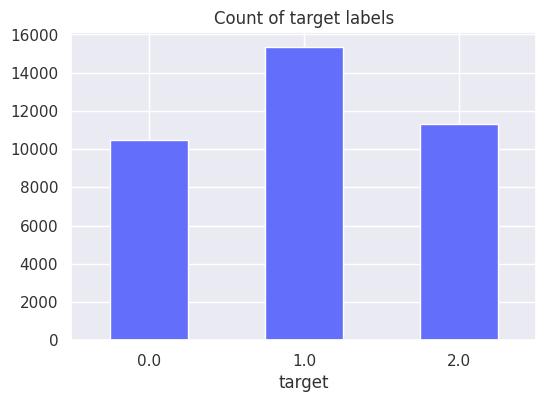

In [ ]:
df["target"].dropna().value_counts().sort_index().plot(kind="bar")
plt.xticks(rotation=0)
plt.xlabel("target")
plt.title("Count of target labels")

## Train-test split & normalize

In [ ]:
X = df.dropna().drop(["time", "target"], axis=1).copy()
y = df.dropna()["target"].copy()

In [ ]:
# Train test split
cutoff_date = "2022-09-01"
time = df["time"]
cutoff_idx = time[time == cutoff_date].index.values[0]

x_train = X[:cutoff_idx]
x_valid = X[cutoff_idx:]
y_train = y[:cutoff_idx]
y_valid = y[cutoff_idx:]

In [ ]:
# Normalize the data
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_valid = scaler.transform(x_valid)

In [ ]:
x_train.mean(), x_train.std()

(-5.762055815509432e-16, 0.9999999999999994)

In [ ]:
x_valid.mean(), x_valid.std()

(0.02942864084022249, 0.8916868235417234)

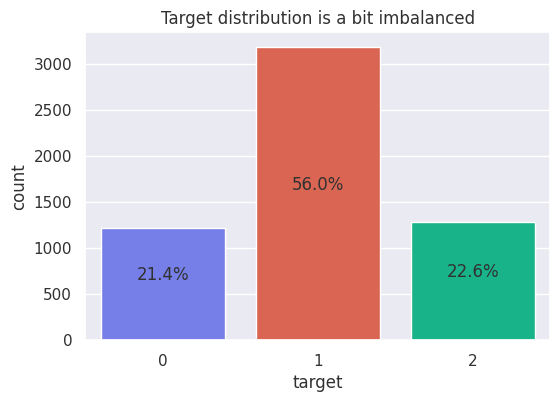

In [ ]:
fig,ax = plt.subplots()
sns.countplot(x=y_valid.astype(int), ax=ax)

# show the count in %
for p in ax.patches:
    h_, w_, x_ = p.get_height(), p.get_width(), p.get_x()
    xy_ = (x_ + w_ / 2., h_ / 2)
    pct = 100 * h_ / y_valid.shape[0]
    text = f'{pct:0.1f}%'
    ax.annotate(text=text, xy=xy_, ha='center', va='bottom')
    
plt.title("Target distribution is a bit imbalanced")
plt.show()

## Transform the dataset into sequences

In [ ]:
class SlidingWindowDataset(Dataset):
    def __init__(
        self,
        x: Tensor,
        y: Optional[Tensor] = None,
        seq_len: int = 1,
        y_position: Optional[int] = None,
    ):
        """
        Creates a sequence of sliding windows from the original X array, and maps each
            window to a target on a specified position within the window.
        Parameters
        ----------
        x: Tensor with features of shape (n_samples, n_features)
        y: Tensor with targets of shape (n_samples, 1)
        seq_len: Window length
        y_position: Position within the window that corresponds to the target.
            By default, the target is mapped to the last window element.
            Can be anything between 0 and seq_len-1.
        """
        super(SlidingWindowDataset, self).__init__()
        self.seq_len = seq_len
        self.x = self.apply_sliding_window_to_x(x)
        self.y_available = y is not None
        if self.y_available:
            assert x.size(0) == y.size(0), "X and y must have equal shape."
            self.y_position = (
                y_position if y_position is not None else seq_len - 1
            )
            assert (
                self.y_position < self.seq_len
            ), f"Y position must be between 0 and sequence length - 1."
            self.y = self.get_y_per_window(y)

    def __len__(self):
        return self.x.size(0)

    def __getitem__(self, index):
        if self.y_available:
            return self.x[index], self.y[index]
        else:
            return self.x[index]

    def apply_sliding_window_to_x(self, x):
        """Transforming an array into a sequence of sliding windows of size:
        (batch, seq_len, n_features)."""
        return x.unfold(dimension=0, size=self.seq_len, step=1).transpose(2, 1)

    def get_y_per_window(self, y):
        start = self.y_position
        end = -self.seq_len + start + 1 if start + 1 != self.seq_len else None
        return y[start:end]

In [ ]:
# Transform X & y into tensors
x_train = torch.tensor(x_train, dtype=torch.float)
x_valid = torch.tensor(x_valid, dtype=torch.float)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_valid = torch.tensor(y_valid.values, dtype=torch.long)

In [ ]:
# Send data to GPU
x_train = x_train.to(device)
x_valid = x_valid.to(device)
y_train = y_train.to(device)
y_valid = y_valid.to(device)

In [ ]:
# Build datasets
ds_train = SlidingWindowDataset(x=x_train, y=y_train, seq_len=SEQ_LEN)
ds_valid = SlidingWindowDataset(x=x_valid, y=y_valid, seq_len=SEQ_LEN)

In [ ]:
valid_pct = 100 * len(ds_valid) / (len(ds_train) + len(ds_valid))
print(f"Validation set size: {round(valid_pct, 1)}%")

Validation set size: 15.1%


In [ ]:
# Calculate class weights for the loss function
class_counts = torch.bincount(y_train)
class_weights = 1 / class_counts
class_weights /= class_weights.sum()

# Train

## Build the transformer architecture

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, n_embedding_dims, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, n_embedding_dims)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, n_embedding_dims, 2).float()
            * (-np.log(10000.0) / n_embedding_dims)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)

In [ ]:
class TimeSeriesClassifier(nn.Module):
    def __init__(
        self, 
        n_features: int,
        n_embedding_dims: int,
        n_head: int,
        n_layers: int,
        n_out: int,
        dropout: float = 0.1,
    ):
        super(TimeSeriesClassifier, self).__init__()
        self.n_embedding_dims = n_embedding_dims
        self.embedding = nn.Linear(n_features, n_embedding_dims)
        self.pos_encoder = PositionalEncoding(n_embedding_dims, dropout)
        self.norm = nn.LayerNorm(n_embedding_dims)
        encoder_layer = TransformerEncoderLayer(n_embedding_dims, n_head)
        self.transformer_encoder = TransformerEncoder(encoder_layer, n_layers)
        self.output_layer = nn.Linear(n_embedding_dims, n_out)

    def forward(self, x):
        out = self.embedding(x)
        out = self.pos_encoder(out)
        out = self.norm(out)
        # PyTorch's TransformerEncoder expects input shape
        # (sequence_length, batch_size, n_embedding_dims), hence permutation twice
        out = out.permute(1, 0, 2)
        out = self.transformer_encoder(out)
        out = out.permute(1, 0, 2)
        out = out[:, -1, :]  # output of the last sequence step
        # out = out.mean(dim=1)  # mean of all sequence steps
        out = self.output_layer(out)
        return out

## Define evaluation mechanism

In [ ]:
def evaluate(y_test: Tensor, y_pred_proba: Tensor) -> None:
    """
    Evaluate model performance by computing metrics
        and plotting precision-recall curve and confusion matrix.
    :param y_test: true target variable
    :param y_pred_proba: prediction probabilities for the positive class (0.0 to 1.0)
    :param threshold: cutoff point to determine the final prediction
    :return: None
    """
    y_test = y_test.cpu()
    y_pred_proba = y_pred_proba.cpu()
    metrics = calculate_metrics(y_test, y_pred_proba)
    print(", ".join([f"{k}: {round(v, 3)}" for k, v in metrics.items()]))
    y_pred = y_pred_proba.argmax(dim=1).detach()
    plot_confusion_matrix(y_test, y_pred)


def calculate_metrics(
    y_test: Tensor, y_pred_proba: Tensor
) -> Dict[str, float]:
    """Calculate all metrics."""
    y_test, y_pred_proba = y_test.detach(), y_pred_proba.detach()
    y_pred = y_pred_proba.argmax(dim=1)
    return {
        "f1": f1_score(
            y_test, y_pred, labels=(0, 1, 2), zero_division=0, average="macro"
        ),
        "avg_precision_score": average_precision_score(
            F.one_hot(y_test, num_classes=3), y_pred_proba, average="macro"
        ),
        "balanced_accuracy": balanced_accuracy_score(
            y_test, y_pred, adjusted=True
        ),
    }


def plot_confusion_matrix(y_test, y_pred) -> None:
    """Plot a confusion matrix on axis."""
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, labels=(0, 1, 2), cmap="Blues"
    )
    plt.grid(False)
    plt.title("Confusion matrix")
    plt.show()

## Train & evaluate the model

In [ ]:
# Create DataLoaders for training and validation sets
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
dl_valid = DataLoader(ds_valid, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# Instantiate the model, loss function, and optimizer
model = TimeSeriesClassifier(
    n_features=x_train.size(1),
    n_embedding_dims=N_EMBEDDING_DIMS,
    n_head=N_HEAD,
    n_layers=N_LAYERS,
    n_out=N_OUT,
    dropout=0.1,
)

# Send model to GPU
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
# TODO 
# # 1. Set weight decay
# learning_rate = None
# weight_decay = None
# optimizer = torch.optim.Adam(
#     model.parameters(), lr=learning_rate, weight_decay=weight_decay
# )

# # 2. Set learning rate decay
# lr_decay_step = None
# lr_decay_magnitude = None
# scheduler = torch.optim.lr_scheduler.StepLR(
#     optimizer, step_size=lr_decay_step, gamma=lr_decay_magnitude,
# )

In [ ]:
# Training loop

train_losses = []
valid_losses = []
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    model.train()
    train_loss = 0.0
    for inputs, targets in dl_train:
        # Perform a forward pass through the model
        output_logits = model(inputs)
        # Compute the loss
        loss = criterion(output_logits, targets)
        # Zero the gradients
        optimizer.zero_grad()
        # Perform a backward pass (backpropagation)
        loss.backward()
        # Update the parameters
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(dl_train)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, targets in dl_valid:
            output_logits = model(inputs)
            loss = criterion(output_logits, targets)
            valid_loss += loss.item()
    valid_loss /= len(dl_valid)
    valid_losses.append(valid_loss)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'model.bin')
        best_valid_loss = valid_loss

    print(
        f"Epoch: {epoch + 1}, Train Loss: {train_loss:.3f}, Validation Loss: {valid_loss:.3f}"
    )

Epoch: 1, Train Loss: 1.087, Validation Loss: 1.161
Epoch: 2, Train Loss: 1.074, Validation Loss: 1.161
Epoch: 3, Train Loss: 1.070, Validation Loss: 1.138
Epoch: 4, Train Loss: 1.069, Validation Loss: 1.117
Epoch: 5, Train Loss: 1.067, Validation Loss: 1.129
Epoch: 6, Train Loss: 1.065, Validation Loss: 1.064
Epoch: 7, Train Loss: 1.064, Validation Loss: 1.079
Epoch: 8, Train Loss: 1.063, Validation Loss: 1.069
Epoch: 9, Train Loss: 1.062, Validation Loss: 1.112
Epoch: 10, Train Loss: 1.061, Validation Loss: 1.073
Epoch: 11, Train Loss: 1.061, Validation Loss: 1.062
Epoch: 12, Train Loss: 1.059, Validation Loss: 1.100
Epoch: 13, Train Loss: 1.059, Validation Loss: 1.098
Epoch: 14, Train Loss: 1.058, Validation Loss: 1.082
Epoch: 15, Train Loss: 1.057, Validation Loss: 1.064
Epoch: 16, Train Loss: 1.055, Validation Loss: 1.102
Epoch: 17, Train Loss: 1.055, Validation Loss: 1.104
Epoch: 18, Train Loss: 1.055, Validation Loss: 1.072
Epoch: 19, Train Loss: 1.054, Validation Loss: 1.093
Ep

In [ ]:
# Load the best model
model.load_state_dict(torch.load('model.bin'))

<All keys matched successfully>

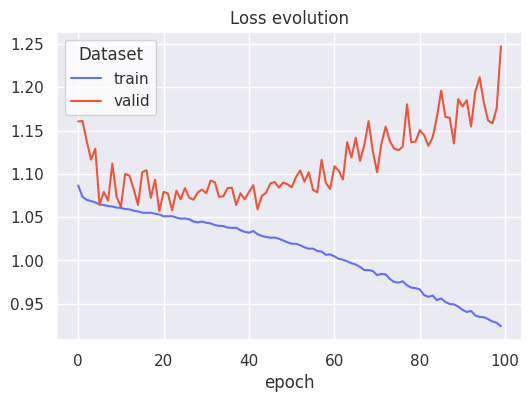

In [ ]:
# Plot loss evolution
plt.plot(train_losses, label="train")
plt.plot(valid_losses, label="valid")
plt.legend(title="Dataset")
plt.title("Loss evolution")
plt.xlabel("epoch")
plt.show()

f1: 0.391, avg_precision_score: 0.404, balanced_accuracy: 0.088


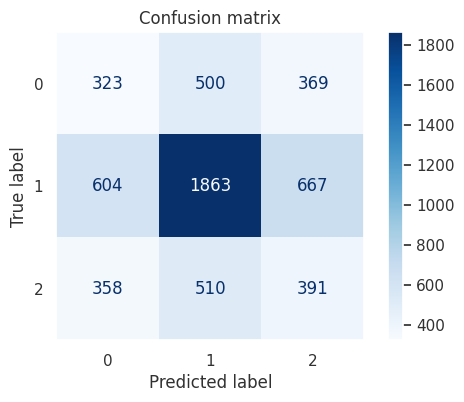

In [ ]:
# Evaluation
model.eval()
y_pred_proba = torch.Tensor([]).to(device)
with torch.no_grad():
    for inputs, targets in dl_valid:
        output_logits = model(inputs)
        batch_pred_proba = F.softmax(output_logits, dim=1)
        y_pred_proba = torch.cat((y_pred_proba, batch_pred_proba), dim=0)

y_true = dl_valid.dataset.y
evaluate(y_true, y_pred_proba)

---